<a href="https://colab.research.google.com/github/mkorlyakova/test_pallet/blob/main/%D0%A0%D0%B0%D0%B1%D0%BE%D1%87%D0%B8%D0%B9_%D0%B2%D0%B0%D1%80%D0%B8%D0%B0%D0%BD%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Инсталяция рабочих пакетов и создание функций

мой GITHub репозиторий для подключения картинок

In [1]:
# Clone the entire repo.
!git clone https://github.com/mkorlyakova/test_pallet.git
!ls

Cloning into 'test_pallet'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 33 (delta 14), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (33/33), done.
sample_data  test_pallet


Библиотека для чтения архива

In [2]:
# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -q -U libarchive


Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 160975 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.2.2-3.1ubuntu0.6_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.2.2-3.1ubuntu0.6) ...
Setting up libarchive-dev:amd64 (3.2.2-3.1ubuntu0.6) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 163kB 11.9MB/s 


Импорт модулей:
 - общие : numpy
 - обработка файлов : glob, libarchive, os
 - чтение и разбор данных : json, cv2, shapely.geometry
 - отрисовка графиков : matplotlib
 - обучение : sklearn, tensorflow
 

In [3]:
import numpy as np
import pandas as pd
from glob import glob
import libarchive

import libarchive.public
import os


import json

import cv2 as cv
import matplotlib.pyplot as plt

In [4]:
from shapely.geometry import Polygon

In [5]:
from sklearn.cluster import DBSCAN
# кластеранализ


In [6]:
import tensorflow as tf




## Подключение и чтение информации

Задаю пути к рабочим каталогам

In [7]:
# отсюда берем архив
path = '/content/test_pallet/задание sm 20210309.zip'

In [8]:
# тут распакум данные
path_image = '/content/image_json/'

In [9]:
#нейросеть
path_net = '/content/test_pallet/'

## Читаем и распаковываем

In [10]:
# проверка рабочего каталога
if os.path.exists(path_image) == False: 
    os.mkdir('..'+path_image)
# переход в рабочий каталог    
os.chdir('..'+path_image)
#  открываем архив
with open(path, 'rb') as f:
    for entry in libarchive.public.memory_pour(f.read()):
        print(entry)
# вернулись в основной каталог
os.chdir('/content')

ArchiveEntry<NAME=[задание.docx] SIZE=(216265)>
ArchiveEntry<NAME=[__MACOSX/._задание.docx] SIZE=(590)>
ArchiveEntry<NAME=[24d8bfc3-af64-4525-9dfc-bab6d1df6cbe_0.jpeg] SIZE=(1599642)>
ArchiveEntry<NAME=[__MACOSX/._24d8bfc3-af64-4525-9dfc-bab6d1df6cbe_0.jpeg] SIZE=(268)>
ArchiveEntry<NAME=[24d8bfc3-af64-4525-9dfc-bab6d1df6cbe_0.jpeg.json] SIZE=(11812)>
ArchiveEntry<NAME=[__MACOSX/._24d8bfc3-af64-4525-9dfc-bab6d1df6cbe_0.jpeg.json] SIZE=(212)>
ArchiveEntry<NAME=[2df842e3-2a23-46f0-8ef5-4e4806cfb92e_0.jpeg] SIZE=(1673789)>
ArchiveEntry<NAME=[__MACOSX/._2df842e3-2a23-46f0-8ef5-4e4806cfb92e_0.jpeg] SIZE=(268)>
ArchiveEntry<NAME=[2df842e3-2a23-46f0-8ef5-4e4806cfb92e_0.jpeg.json] SIZE=(8593)>
ArchiveEntry<NAME=[__MACOSX/._2df842e3-2a23-46f0-8ef5-4e4806cfb92e_0.jpeg.json] SIZE=(212)>
ArchiveEntry<NAME=[47532b0d-96bc-4589-983f-1e3e5700626a_1.jpeg] SIZE=(1543451)>
ArchiveEntry<NAME=[__MACOSX/._47532b0d-96bc-4589-983f-1e3e5700626a_1.jpeg] SIZE=(268)>
ArchiveEntry<NAME=[47532b0d-96bc-4589-983f-1e3

Списки файлов аннотаций и изображений отдельно:

In [11]:
json_arr = glob(path_image+'/*.json')  # список имен аннотаций
jpeg_arr = glob(path_image+'/*.jpeg')  # список имен картинок
print('число аннотаций :',len(json_arr))
print('число картинок :',len(jpeg_arr))

число аннотаций : 5
число картинок : 5


количество совпадает - ок!


Проверим разметку.

## Функции для работы

In [12]:
# визуализация рамки
def rect(img, boundBox, text="", colors_ = (255,255,255), thick = 20):
  '''
  Рисуем ранку на изображении img (по OpenCV2), 
  boundBox - углы рамка (X,Y левого верхнего угла,  X, Y правого нижнего угла), 
  text="" - текст для рамки, 
  colors_ = (255,255,255) - цвет для рамки, 
  thick = 20 -  толщина рамки или если (-1), то рисуем сплошную залитую рпамку
  '''
  x1r,y1r,x2r,y2r = boundBox  # читаем координаты углов
  # размер изображения
  s = img.shape
  # координаты в целые
  x1 = int(np.ceil(x1r)) 
  y1 = int(np.ceil(y1r))
  x2 = int(np.ceil(x2r)) 
  y2 = int(np.ceil(y2r))
  #print(x1,y1,x2,y2)
  #print(colors_)
  # рамка
  cv.rectangle(img, (x1,y1), (x2,y2), colors_, thick)
  # текст рамки
  l = 0
  if text != "":
    l = len(text)*14
  cv.rectangle(img,(x1,y1-22),(x1+l,y1),colors_,-1)
  font = cv.FONT_HERSHEY_SIMPLEX
  cv.putText(img,text,(x1,y1), font, 0.8,(0,0,0),1,cv.LINE_AA)

разметку по аннотации

In [13]:
def annotation_read(image_name, json_arr):
  '''
  поиск и чтение аннотаций
  image_name - имя картинки, 
  json_arr - список имен файлов аннотаций

  вернем: список списков координат рамок box_bound

  '''
  k = json_arr.index(image_name+'.json')

  print('картинка : ',json_arr[k])
  # читаем картинку
  image = cv.imread(image_name)
  # читаем аннотацию
  with open(json_arr[k]) as f:
    decoded_hand = json.load(f)
    box_bound = decoded_hand['boxes']
    #print(box_bound)
    print('число рамок на картинке: ',len(box_bound))
  return  box_bound, image

## Построим признаков:

- центроиды
- коробка из данных json (BoundingBox)
- Размеры по Х, У
- картинки

Метрики: 
- нейросеть


In [14]:
def normalize_img(image, w):
  """Normalizes images: `uint8` -> `float32`."""

  return tf.image.resize(tf.cast(image, tf.float32) / 255.,[w,w])


In [15]:
def feature_prep(box_bound,image, centr = True, wx=32, w = 15):
  '''
  box_bound - рамка (верзний левы и нихний правые углы),
  image- картинка, 
  centr = True - строим картинки для данных из центроида (или False - из рамки ), 
  wx - размер половины картинки по любой оси
  w - число пикселей на расширение рамки в стороны

  Строим признаки:
  Х массив векторов в составе:
   - центроиды (сх, су)
   - коробка из данных json (BoundingBox)
   - Размеры по Х, У (ширина , высота)
  I - картинка вокруг центроида (centr = True) или в рамке из box_bound (centr = Falce)
  '''
  # строим для каждой рамки
  X = []
  I = []
  box_bound_clear = []
  xw=wx
  for i_box in box_bound:
    x = [(i_box[0]+i_box[2])/2, (i_box[1]+i_box[3])/2, 
         i_box[0],i_box[1],i_box[2],i_box[3], 
         i_box[2]-i_box[0], i_box[3]-i_box[1]]
    if centr:
        img = image[int(i_box[0])-w:int(i_box[2])+w,int(i_box[1])-w:int(i_box[3])+w,:].copy()
    else:
        img = image[int(x[0])-xw:int(x[0])+xw,int(x[1])-xw:int(x[1])+xw,:].copy()

    if (img.shape[0]>0) & (img.shape[1]>0):
      X.append(x)
      box_bound_clear.append(i_box)
      # пример из картинки
          
      #print(img.shape)
      img = normalize_img(tf.constant(img),wx * 2)
      I.append(img.numpy())
  X = np.array(X)
  I = np.array(I)
  return X, I, box_bound_clear

In [16]:
def claster_image(box_bound, image , metric_dist =None, e_ps = 3, e_ps_max = 30, im_proc = 0.1,  verbose = 1):
  '''
  Строим кластеризацию по дистанциям от метрики

  вход:
  box_bound - рамки, 
  image - картинка, 
  metric_dist =None - матрица расстояний по метрике, 
  
  гиперпараметры алгоритма
  e_ps = 3, e_ps_max = 30 - по DBSCAN,
  im_proc = 0.1 - часть не отнесенных к кластерам картинок,  
  
  verbose = 1 - визуализировать результат (0 - не визуализировать)

  '''
  
  # картинка для разметки
  image_label = image.copy() 
  # запускаем DBSCAN 
  e_ps = e_ps
  clast = DBSCAN( eps=e_ps,min_samples=2)
  c_rez = clast.fit(metric_dist)

  # проверяем достигнут ли порог распознавания, если нет, 
  # то запускаем цикл адаптации основного парвметра алгоритма 
  while (np.sum(c_rez.labels_==-1)/c_rez.labels_.shape[0] > im_proc) & (e_ps<e_ps_max):
    e_ps += 0.1 # адаптация
    #print(e_ps)
    clast = DBSCAN( eps=e_ps, min_samples=2)
    c_rez = clast.fit(metric_dist)
  # разметка
  n = 0
  colors = []
  # Строим случайных цветов по числу классов
  for j in range(c_rez.labels_.max()+1):
    colors.append((np.random.randint(0,255,size=(3,)).astype(int)))
  # строим раскраску каждой рамки  
  for i_box in box_bound:
    #print(n)
    # определяем класс по разметке кластеранализа
    k = c_rez.labels_[n]
    if k == -1:
      # если кластер не рабочий, то не красим
      thick = 20
    else: 
      thick = -1
      # рисуем рамку цветом
      rect(image_label,i_box, colors_ = (int(colors[k][0]),int(colors[k][1]),int(colors[k][2]),100), thick = thick)
    n += 1 # идем к след.рамке
  # рисунки  
  if verbose:  
    plt.figure(figsize = (7,16))
    plt.subplot(1,2,1)    
    plt.imshow(image)
    plt.title('разметка исходная')
    plt.subplot(1,2,2)   
    plt.imshow(image_label)
    plt.title('разметка результат')
    plt.show()
  return c_rez.labels_, image_label

# Грузим модель

Построим нейронную сеть и загрузим веса.


## Нейронная сеть:
 - 2 входа: вектор Х = <центроид, рамка, размеры рамки >, I = <картинки внутри рамки, выровнена 64х64х3 и  нормализована к [0:1]> 

In [17]:
EMB_SIZE = 50
im_size = [64,64,3]
# поток1 I
inp_x_im = tf.keras.layers.Input(shape=(im_size[0], im_size[1], im_size[2]))
inp_X = tf.keras.layers.Input(shape = (8,))
x1 = tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu')(inp_x_im)
x1 = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(x1)
x1 = tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu')(x1)
x1 = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(x1)
x1 = tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu')(x1)
x1 = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(x1)
x1 = tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu')(x1)
x1 = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(x1)
x1 = tf.keras.layers.Flatten()(x1)
# поток2 Х 
x2 = tf.keras.layers.Dense(256, activation='relu')(inp_X)
x = tf.keras.layers.Concatenate(axis = 1)([x2,x1])
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(EMB_SIZE, activation=None)(x)

model = tf.keras.models.Model( inputs =[inp_x_im,inp_X], outputs = x)

In [18]:
im_size

[64, 64, 3]

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   2432        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   51264       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [20]:
model.load_weights(path_net +'siam_net.h5')

In [21]:
NUM_EPOCHS =3 # число эпох 
NUM_BATCH = 40 # число пакетов

LEARNING_RATE = 0.001 # скорость обучения

# оптимизатор
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
# зазор
MARGIN = 100.0


## Тест нейронной сети



In [22]:
# вычисление метрики для вложеня (Euqlid)
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

# вычисление пар по меткам
#for i in range(len(L)-1):
#  for j in range(i+1,len(L)): 
#    if (lab[j] != -1) & (lab[i] != -1):
#      print(lab[i],' <-> : ',lab[j], ' : ', diff(emb[i], emb[j]))


In [23]:
# метрики по эмбелингу (вложению)
def my_embed_metric(X):
  net_dist = np.ones((X.shape[0],X.shape[0])) # нормированное расстояние - инициализация 1(пока)
  for i in range(X.shape[0]-1):
    for j in range(i+1,X.shape[0]):
      net_dist[i,j] = diff( X[i,2:6],X[j,2:6])
      net_dist[j,i] =  net_dist[i,j]
      
  return net_dist# 

def image_clast_net(image_name='', json_name='', model=None,  w = 15, centr = True, wx=32, e_ps = 30, e_ps_max = 100, im_proc = 0.1, verbose=1):
  '''
  полный цикл для кластер- анализа
  вход:
  image_name - имя картинки, json_arr - имя аннотации, verbose = 0, w = 15
  
  centr = True - строим картинки для данных из центроида (или False - из рамки ), 
  wx - размер половины картинки по любой оси
  w - число пикселей на расширение рамки в стороны  
   
  гиперпараметры алгоритма
  e_ps = 3, e_ps_max = 30 - по DBSCAN,
  im_proc = 0.1 - часть не отнесенных к кластерам картинок,  
  
  verbose = 1 - визуализировать результат (0 - не визуализировать)

  Строим признаки:
  Х массив векторов в составе:
   - центроиды (сх, су)
   - коробка из данных json (BoundingBox)
   - Размеры по Х, У (ширина , высота)
  I - картинка вокруг центроида (centr = True) или в рамке из box_bound (centr = Falce)
  L - разметка по кластеранализу
  iou,n_dist,m_dist - метрики 
  box_bound_clear - рамки
  
  ''' 
  X = []
  I = []
  
  # картинке ставим в соответствие аннотацию
  box_bound, image = annotation_read(image_name, json_arr)
  
  # строим признаки 
  X,I, box_bound_clear = feature_prep(box_bound,image, centr = centr, wx=wx, w = w)
  # строим метрики
  sample = [I,X]
  X_emb = model.predict(sample)
  n_emb = my_embed_metric(X_emb)
  if 0:
    
    plt.figure(figsize = (7,16))
     
    plt.imshow(n_emb)
    plt.title('Эмбединг')
    
    plt.show()
  # кластер-анализ  
  L,img_label = claster_image(box_bound_clear, image , 
                              metric_dist = n_emb, 
                              e_ps = e_ps, e_ps_max = e_ps_max, 
                              im_proc = im_proc,  
                              verbose = verbose)
  return  X, I, L, n_emb, box_bound_clear

Смотрим на картинки , которые участвовали в обучении:
 - разные группы  помечены разными цветами
 - если невидно , то перезапустить
 - немного урезаный список примеров (полный есть в Эксперименте)


картинка :  /content/image_json/24d8bfc3-af64-4525-9dfc-bab6d1df6cbe_0.jpeg.json
число рамок на картинке:  88


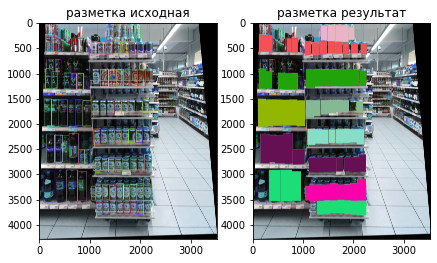

картинка :  /content/image_json/2df842e3-2a23-46f0-8ef5-4e4806cfb92e_0.jpeg.json
число рамок на картинке:  64


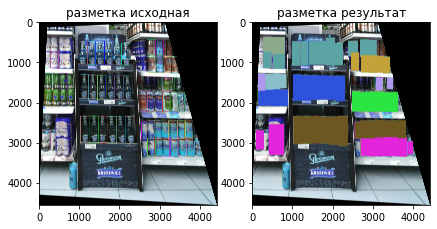

картинка :  /content/image_json/47532b0d-96bc-4589-983f-1e3e5700626a_1.jpeg.json
число рамок на картинке:  65


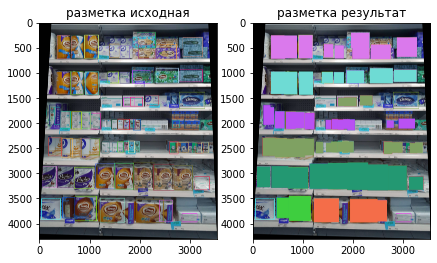

In [30]:
for image_name in jpeg_arr[:-2]:
  _,_,L,emb_,_=image_clast_net(image_name, json_arr, model=model, verbose = 1, w = 15)

Тестовая картинка:
 - разные группы помечены разными цветами
 - если невидно , то перезапустить


 (индекс -2,т.к. картинка на которой тестила прочиталась почему-то 4-й (разберусь с сортировкой списка имен), должна быть тестовая одинаковая в эксперименте и тут)



картинка :  /content/image_json/d3518d48-72d7-47f8-b334-4e61244c4378_0.jpeg.json
число рамок на картинке:  54


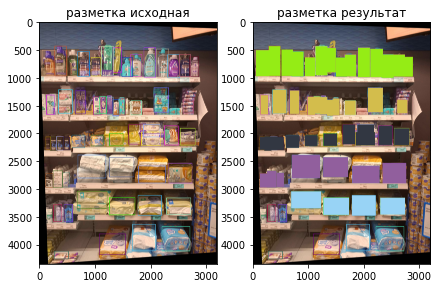

In [29]:
image_name = jpeg_arr[-2]
_,_,L,emb_,_=image_clast_net(image_name, json_arr, model=model, verbose = 1, w = 15)

## Результат 

- тренировочные картинки : некоторые лучше, некоторые похуже - не отличает полку от поставленных друг на друга рядов банок, во многом виновата разметка DBSCANA, по которой учили


- тестовые картинки : не смогли объединить несколько полок (4 объекта - нижняя, маленькая боковая полочка - вторая снизу - 2 или 3 объекта, вообще маленькие полочки (частично видные) старается прицепить к основной полке, которую видим целиком)

- делать реализацию через класс пока нет смысла, т.к. необходимо строить и адаптировать модель дальше, но есть смысл сделать класс для адаптации



